In [8]:
import random
import textwrap
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import HBox, widgets


In [9]:
import tiktoken

encoder = tiktoken.encoding_for_model("gpt-4o")


def count_tokens(text: str) -> int:
    return len(encoder.encode(text))

In [10]:
df = pd.read_json('deepseek-70b-best-results.jsonl', lines=True)
print(len(df))
df.head()

2417


,id,n_hops,answer,hops,predicted_answer,reference_answers,exact_match,f1,fuzzy_match
0,2hop__460946_294723,2,Miquette Giraudy,[{'question': 'Who is the spouse of the Green ...,Miquette Giraudy,[Miquette Giraudy],1,1.000000,1
1,2hop__252311_366220,2,Mike Medavoy,[{'question': 'Who founded the company that di...,Mike Medavoy,[Mike Medavoy],1,1.000000,1
2,2hop__701895_752697,2,Municipality of Nuevo Laredo,[{'question': 'What administrative territorial...,Municipality of Nuevo Laredo,[Tamaulipas],0,0.000000,0
3,2hop__259228_793698,2,"Cologne, Germany",[{'question': 'Where is Ulrich Walter's employ...,"Cologne, Germany",[Cologne],0,0.666667,0
4,2hop__481349_302087,2,Bombardier Inc.,[{'question': 'Which company owns the manufact...,Bombardier Inc.,"[Bombardier Inc., Bombardier]",1,1.000000,1


In [11]:
row = df.iloc[0]
row['hops'][0]

{'question': 'Who is the spouse of the Green performer?',
 'query': 'Who is the spouse of the Green performer?',
 'retrieved_docs': [{'text': '# Miquette Giraudy\nMiquette Giraudy (born 9 February 1953, Nice, France) is a keyboard player and vocalist, best known for her work in Gong and with her partner Steve Hillage. She and Hillage currently form the core of the ambient band System 7. In addition to her performances in music, she has also worked as an actress, film editor and writer. In each role, she has used different stage names.',
   'is_supporting': True,
   'parent_id': '2hop__460946_294723',
   'idx': 5},
  {'text': '# Green (Steve Hillage album)\nGreen is the fourth studio album by British progressive rock musician Steve Hillage. Written in spring 1977 at the same time as his previous album, the funk-inflected "Motivation Radio" (1977), "Green" was originally going to be released as "The Green Album" as a companion to "The Red Album" (the originally intended name for "Motivat

In [12]:
df['generation'] = df['hops'].apply(lambda x: x[0]['qa_result']['generation'])
df['gen_token_count'] = df['generation'].apply(lambda x: count_tokens(x))

In [13]:
success_mask = df['f1'] > 0.5
fail_df = df[~success_mask]
success_df = df[success_mask]
print("Fail:", len(fail_df))
print("Success:", len(success_df))
print("Total:", len(df))
print("Mean F1:", f"{df['f1'].mean():.3f}")

Fail: 738
Success: 1679
Total: 2417
Mean F1: 0.706


In [14]:
df.groupby('n_hops')[['exact_match', 'f1']].agg(['mean', 'count'])

exact_match              f1      
              mean count      mean count
n_hops                                  
2         0.599042  1252  0.750479  1252
3         0.555263   760  0.692036   760
4         0.503704   405  0.597067   405

In [15]:
answered_mask = df['generation'].str.lower().str.contains('answer:')
len(df.loc[~answered_mask]), f"{len(df.loc[~answered_mask]) / len(df):.3f}"

(17, '0.007')

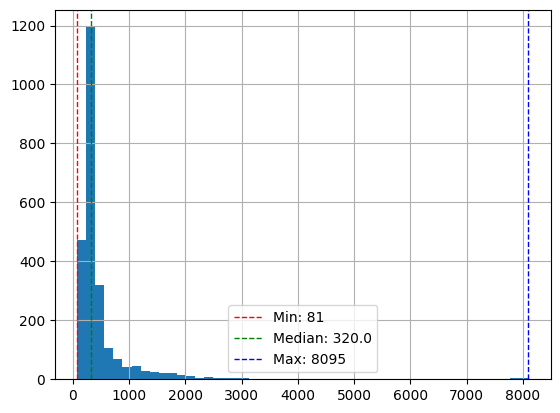

In [16]:
# Plot the histogram
ax = df['gen_token_count'].hist(bins=50)

# Add lines for min, median, and max
min_val = df['gen_token_count'].min()
median_val = df['gen_token_count'].median()
max_val = df['gen_token_count'].max()

plt.axvline(min_val, color='r', linestyle='dashed', linewidth=1, label=f'Min: {min_val}')
plt.axvline(median_val, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_val}')
plt.axvline(max_val, color='b', linestyle='dashed', linewidth=1, label=f'Max: {max_val}')

# Add legend
plt.legend()

# Show plot
plt.show()

In [17]:
def fixedwidth(text):
    return "\n".join(textwrap.wrap(text, width=80, replace_whitespace=False))

def format_row(row):
    context = row['hops'][0]['context']
    question = row['hops'][0]['question']
    generation = row['hops'][0]['qa_result']['generation']

    output = []
    output.append(f"{row['id']} - {row['n_hops']} hops")
    output.append("="*80)
    output.append(fixedwidth(context))
    output.append("="*80)
    output.append("Q: " + question)
    output.append("Reference Answers: " + str(row['reference_answers']))
    output.append("Predicted Answer: " + row['predicted_answer'])
    output.append("-"*80)
    output.append("Generation")
    output.append("-"*80)
    output.append(generation)
    output.append("-"*80)
    output.append("# Scores")
    output.append("EM: {:.3f}".format(row['exact_match']))
    output.append("F1: {:.3f}".format(row['f1']))
    if 'analysis' in row:
        output.append("")
        output.append("# Analysis")
        output.append(fixedwidth(row['analysis']))
    return "\n".join(output)

def present_row(row):
    print(format_row(row))


def create_browse_app(df):
    def browse_failed(i=0):
        row = df.iloc[i]
        present_row(row)

    index = widgets.IntText(value=0, description='Index:')
    left_button = widgets.Button(description='Previous')
    right_button = widgets.Button(description='Next')

    def on_left_button_clicked(b):
        if index.value > 0:
            index.value -= 1

    def on_right_button_clicked(b):
        if index.value < len(df) - 1:
            index.value += 1

    left_button.on_click(on_left_button_clicked)
    right_button.on_click(on_right_button_clicked)

    ui = HBox([left_button, index, right_button])
    out = widgets.interactive_output(browse_failed, {'i': index})

    display(ui, out)


In [18]:
inspect_df = fail_df.sort_values('f1')
create_browse_app(inspect_df)

Output()

In [19]:
unanswered_df = df.loc[~answered_mask]
create_browse_app(unanswered_df)

Output()

In [20]:
answered_failed_df = df.loc[answered_mask & ~success_mask]
create_browse_app(answered_failed_df)

Output()